# Rotation Change
Plot the absolute difference in `alignments3D/pose` for two refinements of the same particles. This calculation is the same as the one performed under the hood in [Subset Particles by Statistic](https://guide.cryosparc.com/processing-data/all-job-types-in-cryosparc/particle-curation/job-subset-particles-by-statistic#cryosparc-dataset-fields) when used in mode "Absolute difference in 3D pose (deg)".

In [1]:
from cryosparc.tools import CryoSPARC
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

with open(Path("~/instance-info.json").expanduser(), "r") as f:
    instance_info = json.load(f)

cs = CryoSPARC(**instance_info)
assert cs.test_connection()

project_uid = "P345"
workspace_uid = "W10"
job_a_uid = "J1032"
job_b_uid = "J942"
job_c_uid = "J1043"

project = cs.find_project(project_uid)

job_a = project.find_job(job_a_uid)
particles_a = job_a.load_output("particles")
particles_a.rename_fields({"alignments3D/pose": "pose_a"})

job_b = project.find_job(job_b_uid)
particles_b = job_b.load_output("particles")
particles_b.rename_fields({"alignments3D/pose": "pose_b"})

job_c = project.find_job(job_c_uid)
particles_c = job_c.load_output("particles")
particles_c.rename_fields({"alignments3D/pose": "pose_c"})
particles = particles_a.innerjoin(particles_b, particles_c).filter_fields(["pose_a", "pose_b", "pose_c"])

Connection succeeded to CryoSPARC API at http://cryoem0.sbi:40002


In [2]:
poses_a = R.from_rotvec(particles["pose_a"])
poses_b = R.from_rotvec(particles["pose_b"])
poses_c = R.from_rotvec(particles["pose_c"])
differences = {
    "ab": [],
    "ac": []
}
for a, b, c in zip(poses_a, poses_b, poses_c):
    a_mat = a.as_matrix()
    diff_mat_ab = a_mat @ b.inv().as_matrix()
    differences["ab"].append(R.from_matrix(diff_mat_ab).magnitude())
    diff_mat_ac = a_mat @ c.inv().as_matrix()
    differences["ac"].append(R.from_matrix(diff_mat_ac).magnitude())

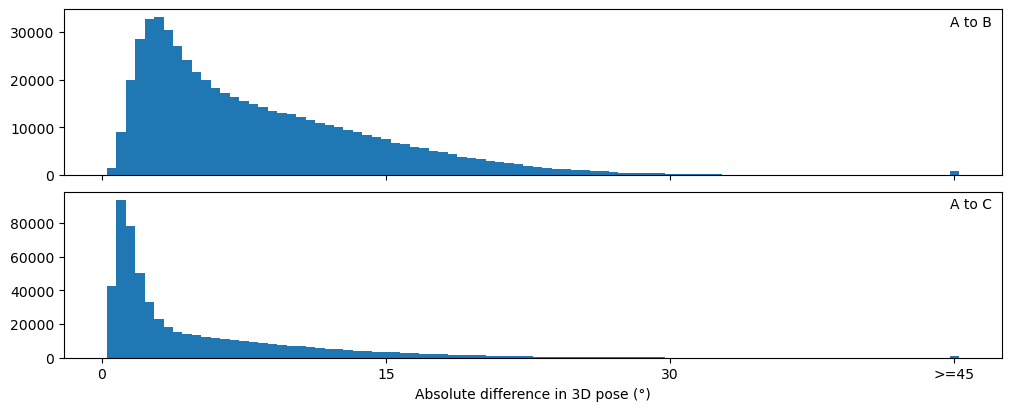

In [15]:
fig, (ax_ab, ax_ac) = plt.subplots(2, 1, figsize = (10, 4), layout = "constrained", sharex = True)
ab_plot = [r if r < np.pi / 4 else np.pi/4 for r in differences["ab"]]
_, bins, _ = ax_ab.hist(
    np.rad2deg(ab_plot),
    bins = 90,
    range = [0, 45],
    align = "right"
)
ax_ab.text(0.99, 0.9, "A to B", transform = ax_ab.transAxes, ha = "right")

ac_plot = [r if r < np.pi / 4 else np.pi/4 for r in differences["ac"]]
ax_ac.hist(
    np.rad2deg(ac_plot),
    bins = bins,
    align = "right"
)
ax_ac.text(0.99, 0.9, "A to C", transform = ax_ac.transAxes, ha = "right")
ax_ac.set_xlabel("Absolute difference in 3D pose (°)")
ax_ac.set_xticks([0, 15, 30, 45])
_ = ax_ac.set_xticklabels(
    ["0", "15", "30", ">=45"]
)